# Using FakeBERT Architecture for Sequence Classification

[Original FakeBERT Paper](https://link.springer.com/content/pdf/10.1007/s11042-020-10183-2.pdf)

FakeBERT Architecture:

![FakeBERT](fakebert.PNG "FakeBERT Architecture")

Summary:

Questions:
* Do we need to split train/test when we load the csv files? I think this should happen in DataLoader
** I would say yes we should have train/validate/test csv files so we can separate our concerns one time and the huggingface library has a useful way to grab data by type in separate CSVs - Megan
* Do we really need a main.py? This could probably be in the notebook
** I agree - Megan


TODO:
- (SKIP) Create config.xml files in config folder and load them into the notebook via the method used in assignments

- Save preprocessed code with the regex (cleaning out newspaper meta data and removing sequences below certain sizze) into data folder so it can be tokenized (test.csv, train.csv, validation.csv)

- (DONE) (for now, run again with preprocessed data files)Run tokenizer code ONCE and save to pickle (to spare the 10 minute runtime every time this notebook loads)

- (DONE) Pull BertModel out of this notebook and use the sources/models/FakeBert.py

- Look at adding the BERT embedding to the nn.Module with the gradients? (maybe why accuracy is not good right now, since it isn't in computation graph?)

- Create a new sources/models/BertLinear.py with a simple nn.Module to turn the embeddings into a linear layer

- Clean the commented out code


In [1]:
# Mount into drive

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# This is the location of the root directory (on github it would be cs7643-project)
# Yours might look different - Megan
# root = '/content/drive/MyDrive/CS7643/Project'
# colleen
root = '/content/drive/MyDrive/Colab Notebooks/dl_project/from_git'

In [3]:
# Detect PY file updates and reload
%load_ext autoreload
%autoreload 2

In [4]:
# %reload_ext autoreload

In [5]:
#%cd drive/MyDrive/Colab\ Notebooks/dl_project
import os
os.chdir(root)
%pwd

'/content/drive/MyDrive/Colab Notebooks/dl_project/from_git'

In [6]:
%ls

data/  notebooks/  source/  wandb/


### Installations

In [7]:
!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7097 sha256=f4031b096aff609145c44731a4c6a48f59b97482eaaaf02bd865ab3fd5a245c4
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText


In [8]:
!pip install transformers
!pip install datasets

     |████████████████████████████████| 4.0 MB 39.1 MB/s 
     |████████████████████████████████| 895 kB 59.5 MB/s 
     |████████████████████████████████| 77 kB 7.7 MB/s 
     |████████████████████████████████| 596 kB 64.3 MB/s 
     |████████████████████████████████| 6.6 MB 55.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 325 kB 33.1 MB/s 
     |████████████████████████████████| 212 kB 95.0 MB/s 
     |████████████████████████████████| 1.1 MB 51.0 MB/s 
     |████████████████████████████████| 136 kB 61.5 MB/s 
     |████████████████████████████████| 127 kB 65.4 MB/s 
     |████████████████████████████████| 271 kB 88.2 MB/s 
     |████████████████████████████████| 94 kB 2.4 MB/s 
     |████████████████████████████████| 144 kB 69.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urll

In [9]:
#!pip install -r 'requirements.txt'
!pip install -r 'notebooks/requirements.txt'

     |████████████████████████████████| 10.4 MB 14.4 MB/s 
     |████████████████████████████████| 1.0 MB 66.8 MB/s 
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [10]:
!pip install wandb -qqq

     |████████████████████████████████| 1.8 MB 23.7 MB/s 
     |████████████████████████████████| 181 kB 68.7 MB/s 
     |████████████████████████████████| 144 kB 83.5 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 


In [11]:
import logging
import time
from platform import python_version

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from torch.autograd import Variable
from transformers import BertTokenizer, BertModel
from torch.optim import Adam, Adadelta
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [12]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("torch==%s" % torch.__version__)
print("sklearn==%s" % sklearn.__version__)
print("transformers==%s" % transformers.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.7.13
pandas==1.3.5
numpy==1.21.6
torch==1.11.0+cu113
sklearn==1.0.2
transformers==4.18.0
matplotlib==3.2.2


In [13]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
# n_gpu = torch.cuda.device_count()
# torch.cuda.get_device_name(0)

device(type='cuda')

### Parameters (Pre-Model/Experiment)


In [ ]:
wandb.config.batch_size = 64
wandb.config.learning_rate = 0.1
wandb.config.epochs = 2

### Load CSV Files 
Question (4/16/22) - This may not be necessary. Can the data be preprocessed and saved to train/test locations for use by the get_data.py I created? -Megan

In [ ]:
train = pd.read_csv(train_fp, usecols=['text', 'label'])
val = pd.read_csv(val_fp, usecols=['text', 'label'])
test = pd.read_csv(test_fp, usecols=['text', 'label'])
df = pd.concat([train, test], ignore_index=True)
df.head()

text  label
0  Ever since Donald Trump got exposed through an...      0
1  A British man posted a picture of Prince Georg...      1
2  The Vietnamese government restricted access to...      1
3  In a new poll that asked Americans to comment ...      0
4  Chancellor Angela Merkel s efforts to forge a ...      1

In [ ]:
print(f'full data: {df.shape[0]} rows, {df.shape[1]} features')

full data: 35919 rows, 2 features


In [ ]:
# target skew?
# 0 = fake news
# 1 = true news
val_cnts = df.label.value_counts().to_frame(name='total')
val_cnts.loc[:,'percent'] = np.round(val_cnts['total'] / df.shape[0], 4)
val_cnts

total  percent
0  18860   0.5251
1  17059   0.4749

In [ ]:
# what text lengths (# characters)?
print('*** text characters ***')
print(f'avg length: {df.text.str.len().mean():0.2f}')
print(f'median length: {df.text.str.len().median()}')
print(f'min length: {df.text.str.len().min():0.2f}')
print(f'max length: {df.text.str.len().max():0.2f}')

*** text characters ***
avg length: 2446.10
median length: 2175.0
min length: 1.00
max length: 51794.00


In [ ]:
# what text lengths (# words)?
print('*** text words ***')
print(f'avg length: {df.text.str.split().str.len().mean():0.2f}')
print(f'median length: {df.text.str.split().str.len().median()}')
print(f'min length: {df.text.str.split().str.len().min():0.2f}')
print(f'max length: {df.text.str.split().str.len().max():0.2f}')

*** text words ***
avg length: 401.74
median length: 360.0
min length: 0.00
max length: 8135.00


In [ ]:
# df[df.text.str.len() == 1].shape
# df[df.text.str.split().str.len() == 0].shape

(511, 2)

In [ ]:
# df.text.str.len().describe()
# df.text.str.split().str.len().describe()

In [ ]:
pd.set_option('display.max_rows', 600)
min_chars = 20
df[df.text.str.len() < min_chars].shape
# df[(df.text.str.len() < min_chars) & (df.label == 1)].loc[21130, 'text']

(561, 2)

In [ ]:
# df[df.text.str.len() < min_chars]

In [ ]:
df.loc[224, :].text

'Just another reason conservatives love Ted Cruz .Share this with everyone '

### Preprocess Data
Question (4/16/22) - This preprocess code can be moved into the source/dataloader folder and done ONCE to generate our Train.csv, Test.csv, and Validation.csv files with proper updates -Megan 

In [ ]:
# remove rows with fewer than 150 characters
min_chars = 150
df = df[df.text.str.len() > min_chars]
df.text.str.len().describe()

count    43595.000000
mean      2541.617938
std       2162.322732
min        151.000000
25%       1349.000000
50%       2231.000000
75%       3148.000000
max      51794.000000
Name: text, dtype: float64

In [ ]:
# clip first 30 characters to eliminate location and source information
clip_idx = 30 # replace with regex function
df.text = df.text.str[clip_idx:] # replace with regex function
# df = clip_loc_and_source_info(df) # use function with regex to remove source and location info
df.head()

text  label
0  sident Tayyip Erdogan said on Thursday that U....      1
1   and most of all, he would follow the law. He ...      0
2  ouse Chief of Staff John Kelly’s comment that ...      1
3   welcomed the new U.S. policy toward Iran and ...      1
4  .S. President Donald Trump arrived in Sicily f...      1

In [ ]:
def clip_text(df, text_column, max_words, method='remove'):
    assert max_words > 1, 'max_words must be > 1'
    assert method in ['remove', 'clip_start', 'clip_end', 'clip_middle'], 'method must be remove, clip_start, clip_end, or clip_middle'
    if method == 'remove':
        return df[df[text_column].str.split().str.len() < max_words]
    elif method == 'clip_start':
        df[text_column] = df[text_column].apply(lambda x: x.split()[:max_words])
    elif method == 'clip_end':
        df[text_column] = df[text_column].apply(lambda x: x.split()[-max_words:])
    elif method == 'clip_middle':
        def clip_text_middle(orig_txt, max_wds):
            new = orig_txt.split()
            while len(new) > max_wds:
                new = new[1:-1]
            return new
        df[text_column] = df[text_column].apply(lambda x: clip_text_middle(x, max_words))
    return df

In [ ]:
# only include file notes less than 500 words
# may try different methods
print(f'original # rows: {df.shape[0]}')
max_words = 500
method = 'remove'
df = clip_text(df, 'text', max_words=max_words, method=method) # can just leave this line, change method
# df = df[df.text.str.split().str.len() < max_words] # exclude samples with > max_words
print(f'clipped data: {df.shape[0]} rows')

original # rows: 43595
clipped data: 31951 rows


In [ ]:
# recheck data skew
val_cnts = df.label.value_counts().to_frame(name='total')
val_cnts.loc[:,'percent'] = np.round(val_cnts['total'] / df.shape[0], 4)
val_cnts

total  percent
0  16268   0.5092
1  15683   0.4908

In [ ]:
df.text.str.split().str.len().describe()

count    31951.000000
mean       275.225877
std        134.219270
min         13.000000
25%        155.000000
50%        300.000000
75%        388.000000
max        499.000000
Name: text, dtype: float64

In [ ]:
df.head()

text  label
0  sident Tayyip Erdogan said on Thursday that U....      1
1   and most of all, he would follow the law. He ...      0
2  ouse Chief of Staff John Kelly’s comment that ...      1
3   welcomed the new U.S. policy toward Iran and ...      1
4  .S. President Donald Trump arrived in Sicily f...      1

In [ ]:
print(f'processed data: {df.shape[0]} rows, {df.shape[1]} features')

processed data: 31951 rows, 2 features


### Sample Data

Question (4/16/22) - This sampling code may no longer be needed as we can batch the preprocessed code in entirety. 

In [ ]:
# start with smaller sample
# samp_pct = 0.1
# samp = df.sample(frac=samp_pct)
samp_size = 1000
samp = df.sample(n=samp_size)
samp.shape

(1000, 2)

In [ ]:
# recheck data skew
val_cnts = samp.label.value_counts().to_frame(name='total')
val_cnts.loc[:,'percent'] = np.round(val_cnts['total'] / samp.shape[0], 4)
val_cnts

total  percent
1    501    0.501
0    499    0.499

### Get dataset, Bert tokens from preprocessed files (data/test.csv, data/train.csv)
Question (4/16/22) - After the preprocess code is completed, can we save the FINAL test, train, validation csv files in the data folder so they can be consumed by my get_data.py berty_data class? - Megan

TODO: When the preprocess code is done, the tokenizer only has to be run once and the resulting torch tensors can be saved. Add an 'if exists' check on the pickled token file to restore it from save rather than go through the 10 minute process of tokenizing each time we run this.

In [15]:
train_fp = 'data/Train_Clean.csv'
val_fp = 'data/Validate_Clean.csv'
test_fp = 'data/Test_Clean.csv'
pretrained_fp = 'bert-base-uncased'
MAX_LENGTH = 100
BATCH_SIZE = 128

In [ ]:
'''
Get the preprocess data from data folder and tokenize and retrieve all data (train, test, validation)
'''
from source.dataloader.get_data import bert_data

bert_data = bert_data(\
                      data_folder = 'data',\
                      train_file = 'Train_Clean.csv',\
                      test_file = 'Test_Clean.csv',\
                      val_file = 'Validate_Clean.csv',\
                      tokenizer_type = pretrained_fp,\
                      data_tokens = None)

# FYI - col_tokenize is name of column containing the sequence text (in case it changes for some reason)
data_tokenized = bert_data.tokenize(\
                                    col_tokenize = 'text',\
                                    add_special_tokens = True,\
                                    max_length = MAX_LENGTH,\
                                    truncation = True,\
                                    padding = 'max_length')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using custom data configuration data-b98c47b1c708a9da


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/26938 [00:00<?, ?ex/s]

  0%|          | 0/8981 [00:00<?, ?ex/s]

  0%|          | 0/8979 [00:00<?, ?ex/s]

In [ ]:
data_tokenized

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'text', 'subject', 'date', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 26938
    })
    test: Dataset({
        features: ['id', 'title', 'text', 'subject', 'date', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8981
    })
    valid: Dataset({
        features: ['id', 'title', 'text', 'subject', 'date', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8979
    })
})

In [ ]:
# # Get train, validation inputs/labels from data_tokenized
# train_inputs = data_tokenized['train']['input_ids'] 
# val_inputs = data_tokenized['test']['input_ids']
# train_labels = data_tokenized['train']['label']
# val_labels = data_tokenized['test']['label']

In [ ]:
# data_tokenized['train']['input_ids'].shape

In [ ]:
# train_dataloader, val_dataloader = bert_data.get_data_loader(train_inputs, val_inputs, train_labels, val_labels)
train_dataloader, val_dataloader, test_dataloader = bert_data.get_data_loader(batch_size=BATCH_SIZE)

### get embeddings using BERT

Each file note becomes a 2D tensor:
* Each row is a token or subtoken in the sequence
* Each column is a value in the embedding (vector) for that token

In [16]:
bert_model = BertModel.from_pretrained(pretrained_fp).to(device)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Parameters (Model)

In [17]:
import random
import time

# Specify loss function
#loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

### build cnn for classification

In [ ]:
# https://chriskhanhtran.github.io/posts/cnn-sentence-classification/

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')

    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
# This was moved into the get_data.py call above
'''
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)

def get_data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=64):
    """Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader
'''

'\nfrom torch.utils.data import (TensorDataset, DataLoader, RandomSampler,\n                              SequentialSampler)\n\ndef get_data_loader(train_inputs, val_inputs, train_labels, val_labels,\n                batch_size=64):\n    """Convert train and validation sets to torch.Tensors and load them to\n    DataLoader.\n    """\n\n    # Convert data type to torch.Tensor\n    train_inputs, val_inputs, train_labels, val_labels =    tuple(torch.tensor(data) for data in\n          [train_inputs, val_inputs, train_labels, val_labels])\n\n    # Create DataLoader for training data\n    train_data = TensorDataset(train_inputs, train_labels)\n    train_sampler = RandomSampler(train_data)\n    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)\n\n    # Create DataLoader for validation data\n    val_data = TensorDataset(val_inputs, val_labels)\n    val_sampler = SequentialSampler(val_data)\n    val_dataloader = DataLoader(val_data, sampler=val_sampler, ba

In [ ]:
# This was moved into the get_data.py call above
'''
from sklearn.model_selection import train_test_split

# Train Test Split
# train_inputs, val_inputs, train_labels, val_labels = train_test_split(
#     X, labels, test_size=0.1, random_state=42)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(bert_embeddings, bert_labels, test_size=0.1, random_state=42)

# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = get_data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=BATCH_SIZE)
'''

'\nfrom sklearn.model_selection import train_test_split\n\n# Train Test Split\n# train_inputs, val_inputs, train_labels, val_labels = train_test_split(\n#     X, labels, test_size=0.1, random_state=42)\ntrain_inputs, val_inputs, train_labels, val_labels = train_test_split(bert_embeddings, bert_labels, test_size=0.1, random_state=42)\n\n# Load data to PyTorch DataLoader\ntrain_dataloader, val_dataloader = get_data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=BATCH_SIZE)\n'

In [ ]:
# train_features, train_labels = next(iter(train_dataloader))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")

In [ ]:
# This was moved to source/models/FakeBERT.py
'''
class FakeBERTCNN(nn.Module):
    # def __init__(self, pretrained_embedding, emb_dim, filter_sizes=[3, 4, 5], num_filters=[100, 100, 100], num_classes=2, dropout_p=0.2):
    def __init__(self, emb_dim, filter_sizes=[3, 4, 5], num_filters=[100, 100, 100], num_classes=2, dropout_p=0.2):
        super(FakeBERTCNN, self).__init__()

        # CNN
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=emb_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc1 = nn.Linear(np.sum(num_filters), num_classes)

        # # add parameters for these layers
        # self.conv1d1 = nn.Conv1d()
        # self.pool1 = nn.MaxPool1d()
        # self.conv1d2 = nn.Conv1d()
        # self.pool2 = nn.MaxPool1d()
        # self.flat = nn.Flatten()
        # self.fc2 = nn.Linear()
        # self.fc3 = nn.Linear()

        self.dropout = nn.Dropout(p=dropout_p)
        self.relu = nn.ReLU()

    # def forward(self, input_ids):
    def forward(self, x_embed):

            # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
            # Output shape: (b, embed_dim, max_len)
            x_reshaped = x_embed.permute(0, 2, 1)

            # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
            x_conv_list = [self.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

            # Max pooling. Output shape: (b, num_filters[i], 1)
            x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
                for x_conv in x_conv_list]
            
            # Concatenate x_pool_list to feed the fully connected layer.
            # Output shape: (b, sum(num_filters))
            x_fc1 = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                            dim=1)
            
            # Compute logits. Output shape: (b, n_classes)
            logits = self.fc1(self.dropout(x_fc1))

            return logits
'''

In [ ]:
# def initialize_model(pretrained_embedding, embed_dim, filter_sizes, num_filters,
#                     num_classes, dropout=0.2, learning_rate=0.01):

# This was moved to FakeBERT file since it is initialize code for FakeBERT Specifically
'''
def initialize_model(embed_dim, filter_sizes, num_filters, num_classes,
                     dropout=0.2, learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = FakeBERTCNN(emb_dim=embed_dim,
                            filter_sizes=filter_sizes,
                            num_filters=num_filters,
                            num_classes=num_classes,
                            dropout_p=dropout)
    
    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate Adadelta optimizer
    # optimizer = Adadelta(cnn_model.parameters(), lr=learning_rate, rho=0.95)
    optimizer = Adam(cnn_model.parameters(), lr=learning_rate)

    return cnn_model, optimizer
'''

### run training data through BERT and CNN



In [ ]:
import random
import time

# Specify loss function
#loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

'''
def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=5):
    """Train the CNN model."""
    
    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {\
    'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()
        progress_bar = tqdm(train_dataloader, ascii=True)

        for step, batch in enumerate(progress_bar):
          # Load batch to GPU
          b_input_ids, b_labels = tuple(t.to(device) for t in batch)

          # Get embeddings for current batch
          with torch.no_grad():
            embeddings = bert_model(b_input_ids.to(device))[0]

          # Zero out any previously calculated gradients
          model.zero_grad()

          # Perform a forward pass. This will return logits.
          logits = model(embeddings)

          # Compute loss and accumulate the loss values
          loss = loss_fn(logits, b_labels)
          total_loss += loss.item()

          # Perform a backward pass to calculate gradients
          loss.backward()

          # Update parameters
          optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {\
            val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        # Get embeddings for current batch
        with torch.no_grad():
            embeddings = bert_model(b_input_ids.to(device))[0]

        # Compute logits
        with torch.no_grad():
            logits = model(embeddings)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy
'''

##Example Experiment

In [18]:
import pprint
myrun=wandb.init(project="FakeBERT_Colleen", entity="cs7643-teamscam")

wandb: Currently logged in as: cs7643-teamscam (use `wandb login --relogin` to force relogin)


In [ ]:
# NEW SWEEP WITH NUM_FILTERS AND FILTER_SIZES
# set sweep configuration
sweep_config = {
    'method': 'random',#grid, random
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'learning_rate': {
            'values': [1e-1]
        },
        'batch_size': {
            'values': [64, 128] 
        },
        'epochs':{
            'values':[10],
        },
        'max_length':{
            'values':[100]
        },
        'dropout':{
            'values':[0.2]
        },
        'opt':{
            'values':['ada']
        },
        'rho':{
            'values':[0.9] # 0.9 is default, paper doesn't specify
        },
        'emb_size':{ 
            'value':768 # should not change
        },
        'num_filters':{
            'values':[[128, 128, 128], [256, 256, 256]] # [128, 128, 128] in paper
        },
        'filter_sizes':{
            'values':[[3, 4, 5], [6, 7, 8], [7, 7, 7]]
        },
        'num_classes':{ 
            'value':2 # should not change (with standard dataset)
        },
        'test_subset':{
            'value': False # set to true to do quick test
        },
        'test_data': {
            'value':'LiarLiar' #'ISOT'
        },
        'alt_test':{
            'value': True # set to true to test other than ISOT data
        }
    }
}

In [19]:
# SWEEP # 1
# set sweep configuration
sweep_config = {
    'method': 'random',#grid, random
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'learning_rate': {
            'values': [1e-1, 1e-3]
        },
        'batch_size': {
            'values': [64, 128] 
        },
        'epochs':{
            'values':[5, 10, 15]#5, 
        },
        'max_length':{
            'values':[100, 200]
        },
        'dropout':{
            'values':[0.2, 0.4]
        },
        'opt':{
            'values':['ada']
        },
        'rho':{
            'values':[0.9] # 0.9 is default, paper doesn't specify
        },
        'emb_size':{ 
            'value':768 # should not change
        },
        'num_filters':{
            'value':[128, 128, 128] # [128, 128, 128] in paper
        },
        'filter_sizes':{
            'value':[3, 4, 5] # [3, 4, 5] in paper
        },
        'num_classes':{ 
            'value':2 # should not change (with standard dataset)
        },
        'test_subset':{
            'value': False # set to true to do quick test
        },
        'test_data': {
            'value':'LiarLiar' #'ISOT'
        },
        'alt_test':{
            'value': True # set to true to test other than ISOT data
        }
    }
}

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: k6qjtsi4
Sweep URL: https://wandb.ai/cs7643-teamscam/FakeBERT_Colleen/sweeps/k6qjtsi4


wandb: Agent Starting Run: 7fl4hnip with config:
wandb: 	alt_test: True
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	emb_size: 768
wandb: 	epochs: 5
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.001
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: ada
wandb: 	rho: 0.9
wandb: 	test_data: LiarLiar
wandb: 	test_subset: False
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Using custom data configuration data-b98c47b1c708a9da


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/26938 [00:00<?, ?ex/s]

  0%|          | 0/8981 [00:00<?, ?ex/s]

  0%|          | 0/8979 [00:00<?, ?ex/s]

Using custom data configuration data-8d423b475df6a0fb


Using liar dataset for test...


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1590 [00:00<?, ?ex/s]

Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   1    |   0.692319   |   51.90   |  0.691715  |   51.67   |  216.71  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   2    |   0.691166   |   52.37   |  0.691348  |   51.67   |  217.34  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   3    |   0.690505   |   52.98   |  0.690996  |   51.67   |  217.22  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   4    |   0.690847   |   52.62   |  0.690544  |   51.67   |  217.55  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   5    |   0.689893   |   53.05   |  0.690142  |   51.67   |  217.36  


Training complete! Best accuracy: 51.67%.
epochs: [0. 1. 2. 3. 4.] 
train_loss: [0.69231893 0.6911661  0.69050459 0.69084732 0.68989339] 
val_loss: [0.69171457 0.69134825 0.6909958  0.69054381 0.69014172]


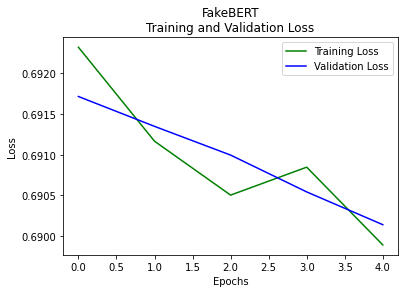

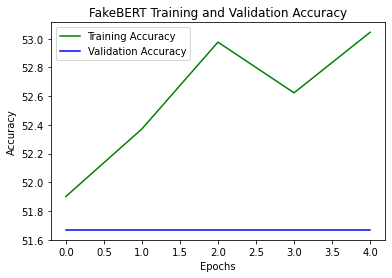

  0%|          | 0/13 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.7086597956143893,43.20913461538461)


wandb: Agent Starting Run: ma5bkueb with config:
wandb: 	alt_test: True
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	emb_size: 768
wandb: 	epochs: 15
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.1
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: ada
wandb: 	rho: 0.9
wandb: 	test_data: LiarLiar
wandb: 	test_subset: False
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-b98c47b1c708a9da
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-fa4c060bb8bac118.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d24869627cdcd1e3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-81927da523dd770a.arrow
Using custom data configuration data-8d423b475df6a0fb
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


Using liar dataset for test...


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-eb32bb35da2fec80.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-7fbfb1c7d34f56b1.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   1    |   0.628019   |   62.83   |  0.443327  |   78.94   |  218.68  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   2    |   0.256367   |   89.66   |  0.164675  |   93.72   |  220.48  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   3    |   0.138764   |   95.12   |  0.127933  |   95.38   |  218.62  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   4    |   0.101871   |   96.49   |  0.134478  |   94.97   |  217.27  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   5    |   0.068673   |   97.63   |  0.164822  |   93.63   |  217.49  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   6    |   0.048258   |   98.42   |  0.080324  |   97.11   |  219.04  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   7    |   0.028332   |   99.10   |  0.078662  |   97.46   |  219.41  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   8    |   0.013969   |   99.66   |  0.080681  |   97.36   |  217.34  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   9    |   0.006733   |   99.87   |  0.089157  |   97.47   |  219.91  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  10    |   0.002914   |   99.99   |  0.096554  |   97.30   |  217.85  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  11    |   0.001568   |  100.00   |  0.098929  |   97.37   |  217.39  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  12    |   0.001127   |  100.00   |  0.101311  |   97.38   |  217.65  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  13    |   0.000826   |  100.00   |  0.111960  |   97.04   |  217.61  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  14    |   0.000648   |  100.00   |  0.112001  |   97.41   |  217.40  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  15    |   0.000524   |  100.00   |  0.112313  |   97.40   |  217.60  


Training complete! Best accuracy: 97.47%.
epochs: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.] 
train_loss: [6.28019487e-01 2.56367474e-01 1.38763917e-01 1.01870850e-01
 6.86733629e-02 4.82579320e-02 2.83319678e-02 1.39692762e-02
 6.73297370e-03 2.91389274e-03 1.56785653e-03 1.12707161e-03
 8.26044748e-04 6.47608950e-04 5.23530393e-04] 
val_loss: [0.44332658 0.16467489 0.12793272 0.1344781  0.16482153 0.08032432
 0.07866198 0.08068059 0.08915697 0.09655388 0.09892883 0.10131124
 0.11195979 0.1120015  0.11231341]


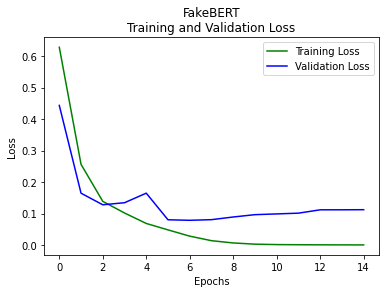

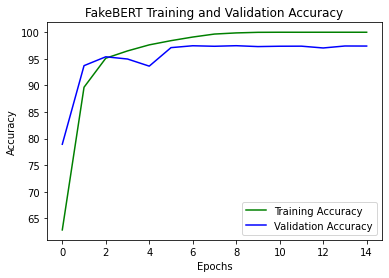

  0%|          | 0/13 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (3.7232887744903564,48.811431623931625)


wandb: Agent Starting Run: 5gfuk14i with config:
wandb: 	alt_test: True
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	emb_size: 768
wandb: 	epochs: 5
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.001
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: ada
wandb: 	rho: 0.9
wandb: 	test_data: LiarLiar
wandb: 	test_subset: False
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-b98c47b1c708a9da
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-fa4c060bb8bac118.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d24869627cdcd1e3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-81927da523dd770a.arrow
Using custom data configuration data-8d423b475df6a0fb
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


Using liar dataset for test...


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-eb32bb35da2fec80.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-7fbfb1c7d34f56b1.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   1    |   0.691873   |   52.41   |  0.691698  |   51.67   |  218.75  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   2    |   0.690945   |   52.83   |  0.691321  |   51.67   |  217.48  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   3    |   0.690247   |   52.79   |  0.690949  |   51.67   |  217.42  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   4    |   0.690103   |   52.75   |  0.690474  |   51.67   |  217.37  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   5    |   0.689455   |   52.67   |  0.690051  |   51.67   |  217.54  


Training complete! Best accuracy: 51.67%.
epochs: [0. 1. 2. 3. 4.] 
train_loss: [0.6918729  0.69094478 0.69024654 0.69010275 0.68945519] 
val_loss: [0.6916981  0.69132146 0.69094864 0.69047362 0.69005141]


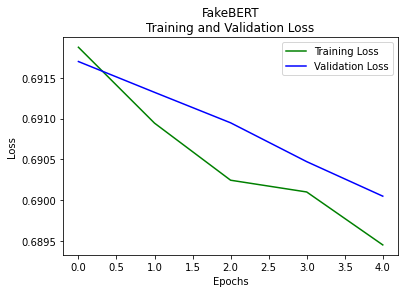

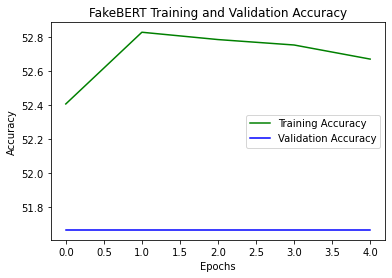

  0%|          | 0/13 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.7092194282091581,43.20913461538461)


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zzttkks2 with config:
wandb: 	alt_test: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	emb_size: 768
wandb: 	epochs: 15
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.001
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: ada
wandb: 	rho: 0.9
wandb: 	test_data: LiarLiar
wandb: 	test_subset: False
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-b98c47b1c708a9da
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-fa4c060bb8bac118.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d24869627cdcd1e3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-81927da523dd770a.arrow
Using custom data configuration data-8d423b475df6a0fb
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


Using liar dataset for test...


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-eb32bb35da2fec80.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-7fbfb1c7d34f56b1.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   1    |   0.692782   |   51.24   |  0.691292  |   51.55   |  227.75  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   2    |   0.690043   |   52.92   |  0.690563  |   51.55   |  226.48  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   3    |   0.689628   |   53.12   |  0.689802  |   51.55   |  227.04  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   4    |   0.688499   |   53.34   |  0.688899  |   51.55   |  226.44  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   5    |   0.687993   |   53.66   |  0.688051  |   51.55   |  226.33  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   6    |   0.686852   |   53.73   |  0.687058  |   51.55   |  227.14  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   7    |   0.685706   |   53.68   |  0.685859  |   51.62   |  227.78  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   8    |   0.684872   |   54.27   |  0.684822  |   51.67   |  232.01  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   9    |   0.683717   |   54.21   |  0.683576  |   52.40   |  227.91  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  10    |   0.682101   |   55.25   |  0.682384  |   52.69   |  227.63  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  11    |   0.681449   |   55.23   |  0.681052  |   53.46   |  227.61  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  12    |   0.679808   |   56.31   |  0.679596  |   54.59   |  227.81  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  13    |   0.677944   |   56.60   |  0.677994  |   56.53   |  229.08  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  14    |   0.676534   |   57.72   |  0.676256  |   58.20   |  227.95  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  15    |   0.675208   |   57.83   |  0.674603  |   58.21   |  227.74  


Training complete! Best accuracy: 58.21%.
epochs: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.] 
train_loss: [0.69278203 0.69004259 0.68962841 0.68849942 0.68799304 0.68685163
 0.68570556 0.68487226 0.68371658 0.68210111 0.68144897 0.67980767
 0.67794443 0.67653415 0.67520787] 
val_loss: [0.69129248 0.6905626  0.68980233 0.68889875 0.68805079 0.6870577
 0.68585895 0.68482216 0.68357588 0.68238372 0.68105198 0.67959596
 0.67799372 0.67625633 0.67460308]


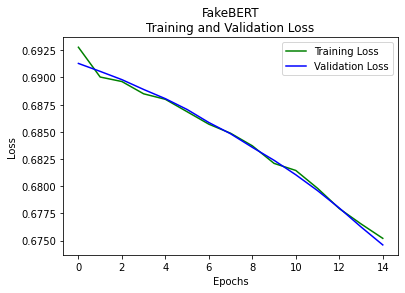

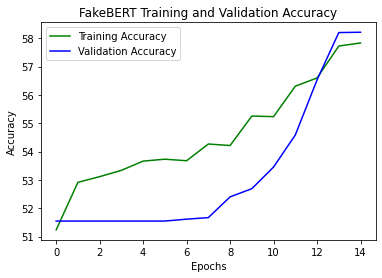

  0%|          | 0/25 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.7739147019386291,42.9375)


wandb: Agent Starting Run: 8lo1s6u5 with config:
wandb: 	alt_test: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	emb_size: 768
wandb: 	epochs: 15
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.001
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: ada
wandb: 	rho: 0.9
wandb: 	test_data: LiarLiar
wandb: 	test_subset: False
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-b98c47b1c708a9da
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-fa4c060bb8bac118.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d24869627cdcd1e3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-81927da523dd770a.arrow
Using custom data configuration data-8d423b475df6a0fb
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


Using liar dataset for test...


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-eb32bb35da2fec80.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-7fbfb1c7d34f56b1.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   1    |   0.692237   |   51.38   |  0.691248  |   51.55   |  228.35  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   2    |   0.689610   |   52.91   |  0.690480  |   51.55   |  226.82  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   3    |   0.689152   |   52.93   |  0.689671  |   51.55   |  226.67  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   4    |   0.688191   |   52.75   |  0.688669  |   51.55   |  226.34  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   5    |   0.687011   |   53.14   |  0.687774  |   51.55   |  226.73  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   6    |   0.685918   |   53.45   |  0.686690  |   51.54   |  226.66  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   7    |   0.684996   |   53.49   |  0.685317  |   51.75   |  228.20  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   8    |   0.683744   |   54.23   |  0.684146  |   51.93   |  227.84  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   9    |   0.682437   |   54.33   |  0.682732  |   52.87   |  227.92  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  10    |   0.681138   |   55.37   |  0.681360  |   53.51   |  228.13  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  11    |   0.679562   |   56.13   |  0.679850  |   54.22   |  228.98  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  12    |   0.677906   |   56.70   |  0.678110  |   56.03   |  228.01  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  13    |   0.675648   |   57.80   |  0.676172  |   57.99   |  228.49  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  14    |   0.674122   |   58.68   |  0.674079  |   59.76   |  230.51  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  15    |   0.672163   |   59.53   |  0.672006  |   59.68   |  226.82  


Training complete! Best accuracy: 59.76%.
epochs: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.] 
train_loss: [0.69223708 0.68960986 0.689152   0.68819141 0.68701126 0.6859179
 0.68499603 0.6837442  0.68243716 0.68113769 0.67956245 0.67790564
 0.67564845 0.67412157 0.67216324] 
val_loss: [0.69124839 0.69048016 0.68967108 0.68866939 0.68777444 0.68669011
 0.68531667 0.68414639 0.68273165 0.68136033 0.67984995 0.67810952
 0.67617193 0.6740789  0.67200568]


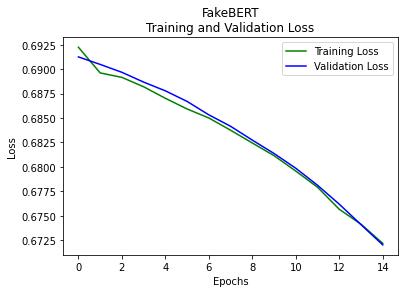

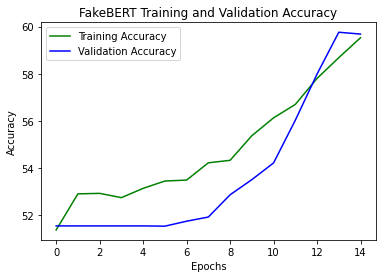

  0%|          | 0/25 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.7894910645484924,42.9375)


wandb: Agent Starting Run: nr5l6q41 with config:
wandb: 	alt_test: True
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	emb_size: 768
wandb: 	epochs: 10
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.001
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: ada
wandb: 	rho: 0.9
wandb: 	test_data: LiarLiar
wandb: 	test_subset: False
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-b98c47b1c708a9da
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-fa4c060bb8bac118.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d24869627cdcd1e3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-81927da523dd770a.arrow
Using custom data configuration data-8d423b475df6a0fb
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


Using liar dataset for test...


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-eb32bb35da2fec80.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-7fbfb1c7d34f56b1.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   1    |   0.692319   |   51.90   |  0.691715  |   51.67   |  218.88  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   2    |   0.691166   |   52.37   |  0.691348  |   51.67   |  218.07  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   3    |   0.690505   |   52.98   |  0.690996  |   51.67   |  217.80  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   4    |   0.690847   |   52.62   |  0.690544  |   51.67   |  217.75  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   5    |   0.689893   |   53.05   |  0.690142  |   51.67   |  217.82  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   6    |   0.689868   |   52.94   |  0.689692  |   51.67   |  217.62  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   7    |   0.689136   |   52.83   |  0.689222  |   51.67   |  219.07  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   8    |   0.688676   |   53.10   |  0.688778  |   51.67   |  218.01  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   9    |   0.688163   |   53.03   |  0.688288  |   51.67   |  217.73  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  10    |   0.687813   |   53.70   |  0.687843  |   51.67   |  219.46  


Training complete! Best accuracy: 51.67%.
epochs: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] 
train_loss: [0.69231893 0.6911661  0.69050459 0.69084732 0.68989339 0.6898676
 0.68913601 0.68867554 0.6881633  0.68781314] 
val_loss: [0.69171457 0.69134825 0.6909958  0.69054381 0.69014172 0.68969215
 0.68922204 0.6887776  0.68828815 0.68784303]


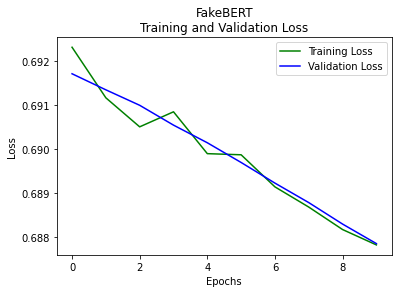

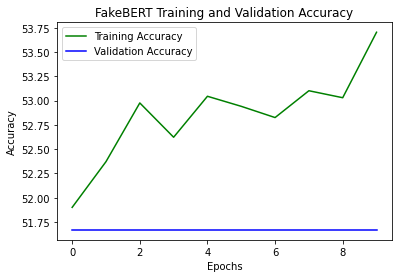

  0%|          | 0/13 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.7157107866727389,43.20913461538461)


wandb: Agent Starting Run: n5dd1bcv with config:
wandb: 	alt_test: True
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	emb_size: 768
wandb: 	epochs: 10
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.1
wandb: 	max_length: 200
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: ada
wandb: 	rho: 0.9
wandb: 	test_data: LiarLiar
wandb: 	test_subset: False
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-b98c47b1c708a9da
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/26938 [00:00<?, ?ex/s]

  0%|          | 0/8981 [00:00<?, ?ex/s]

  0%|          | 0/8979 [00:00<?, ?ex/s]

Using custom data configuration data-8d423b475df6a0fb
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


Using liar dataset for test...


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-eb32bb35da2fec80.arrow


  0%|          | 0/1590 [00:00<?, ?ex/s]

Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   1    |   0.610566   |   64.76   |  0.336371  |   86.69   |  441.34  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   2    |   0.202656   |   92.10   |  0.128873  |   95.49   |  443.04  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   3    |   0.103558   |   96.59   |  0.088402  |   96.96   |  443.21  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   4    |   0.066658   |   97.79   |  0.078285  |   97.08   |  443.46  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   5    |   0.039667   |   98.67   |  0.064087  |   97.63   |  444.59  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   6    |   0.022888   |   99.30   |  0.058282  |   98.02   |  443.87  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   7    |   0.010002   |   99.75   |  0.057075  |   98.16   |  443.51  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   8    |   0.003620   |   99.95   |  0.065497  |   98.12   |  442.19  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   9    |   0.002028   |   99.98   |  0.073724  |   98.06   |  442.40  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  10    |   0.001172   |  100.00   |  0.067066  |   98.14   |  442.26  


Training complete! Best accuracy: 98.16%.
epochs: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] 
train_loss: [0.61056579 0.20265586 0.10355794 0.06665754 0.03966693 0.02288811
 0.01000209 0.00361968 0.00202847 0.00117188] 
val_loss: [0.33637071 0.12887292 0.0884018  0.07828528 0.06408675 0.05828187
 0.05707451 0.06549711 0.07372367 0.06706571]


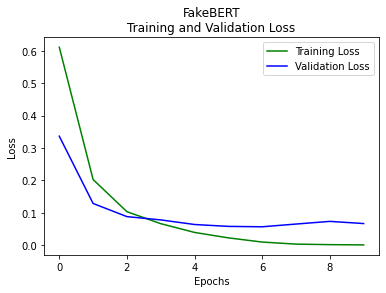

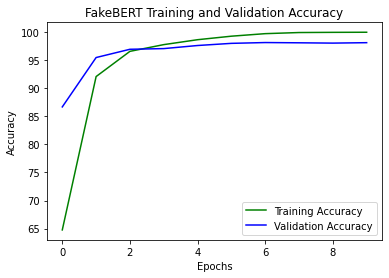

  0%|          | 0/13 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (3.151928369815533,49.510327635327634)


wandb: Agent Starting Run: 0yiiwuzn with config:
wandb: 	alt_test: True
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	emb_size: 768
wandb: 	epochs: 15
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.001
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: ada
wandb: 	rho: 0.9
wandb: 	test_data: LiarLiar
wandb: 	test_subset: False
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-b98c47b1c708a9da
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-fa4c060bb8bac118.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d24869627cdcd1e3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-81927da523dd770a.arrow
Using custom data configuration data-8d423b475df6a0fb
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


Using liar dataset for test...


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-eb32bb35da2fec80.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-7fbfb1c7d34f56b1.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   1    |   0.691873   |   52.41   |  0.691698  |   51.67   |  219.12  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   2    |   0.690945   |   52.83   |  0.691321  |   51.67   |  218.20  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   3    |   0.690247   |   52.79   |  0.690949  |   51.67   |  218.34  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   4    |   0.690103   |   52.75   |  0.690474  |   51.67   |  218.21  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   5    |   0.689455   |   52.67   |  0.690051  |   51.67   |  218.03  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   6    |   0.689158   |   52.81   |  0.689586  |   51.67   |  217.93  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   7    |   0.688424   |   52.85   |  0.689057  |   51.67   |  217.91  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   8    |   0.688154   |   52.90   |  0.688592  |   51.67   |  217.87  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   9    |   0.687717   |   52.97   |  0.688062  |   51.67   |  218.27  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  10    |   0.687298   |   53.23   |  0.687585  |   51.67   |  217.89  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  11    |   0.686578   |   53.23   |  0.687090  |   51.67   |  217.81  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  12    |   0.685766   |   53.16   |  0.686540  |   51.67   |  217.69  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  13    |   0.685224   |   53.50   |  0.685944  |   51.68   |  219.20  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  14    |   0.684964   |   53.57   |  0.685348  |   51.80   |  219.15  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  15    |   0.684316   |   54.11   |  0.684754  |   51.82   |  220.04  


Training complete! Best accuracy: 51.82%.
epochs: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.] 
train_loss: [0.6918729  0.69094478 0.69024654 0.69010275 0.68945519 0.68915799
 0.6884243  0.68815371 0.68771689 0.6872979  0.68657755 0.68576624
 0.68522432 0.68496404 0.68431634] 
val_loss: [0.6916981  0.69132146 0.69094864 0.69047362 0.69005141 0.68958564
 0.68905726 0.6885917  0.68806193 0.68758527 0.68708996 0.68654031
 0.68594446 0.6853475  0.68475367]


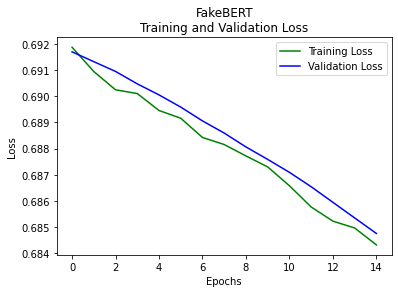

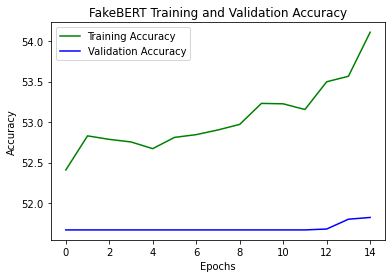

  0%|          | 0/13 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.7278909683227539,43.20913461538461)


wandb: Agent Starting Run: uisxaqd0 with config:
wandb: 	alt_test: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	emb_size: 768
wandb: 	epochs: 15
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.1
wandb: 	max_length: 200
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: ada
wandb: 	rho: 0.9
wandb: 	test_data: LiarLiar
wandb: 	test_subset: False
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-b98c47b1c708a9da
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-bdbcae75353e884b.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b458caac95e427a4.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-1de798b555efd6e7.arrow
Using custom data configuration data-8d423b475df6a0fb
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


Using liar dataset for test...


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-eb32bb35da2fec80.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-30bde11b2f1acbab.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   1    |   0.451188   |   75.93   |  0.184416  |   93.07   |  442.65  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   2    |   0.122567   |   95.74   |  0.092490  |   96.90   |  442.52  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   3    |   0.074149   |   97.48   |  0.072399  |   97.44   |  444.01  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   4    |   0.045974   |   98.47   |  0.060006  |   97.82   |  442.92  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   5    |   0.024086   |   99.21   |  0.056214  |   98.17   |  442.58  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   6    |   0.012047   |   99.60   |  0.050879  |   98.28   |  441.86  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   7    |   0.004947   |   99.87   |  0.067373  |   98.20   |  440.45  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   8    |   0.002549   |   99.93   |  0.067399  |   98.24   |  440.61  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   9    |   0.001200   |   99.98   |  0.073287  |   98.37   |  442.01  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  10    |   0.000952   |   99.99   |  0.081721  |   98.22   |  440.79  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  11    |   0.000362   |  100.00   |  0.079762  |   98.24   |  440.51  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  12    |   0.000488   |   99.99   |  0.079189  |   98.25   |  440.59  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  13    |   0.000218   |  100.00   |  0.093165  |   98.12   |  441.28  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  14    |   0.000204   |  100.00   |  0.077838  |   98.38   |  443.87  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  15    |   0.000165   |  100.00   |  0.085521  |   98.28   |  441.34  


Training complete! Best accuracy: 98.38%.
epochs: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.] 
train_loss: [4.51187695e-01 1.22567058e-01 7.41492818e-02 4.59735489e-02
 2.40862965e-02 1.20468071e-02 4.94650705e-03 2.54931863e-03
 1.20004420e-03 9.51840083e-04 3.62454713e-04 4.88252614e-04
 2.18108016e-04 2.03507809e-04 1.65336730e-04] 
val_loss: [0.18441648 0.0924899  0.07239874 0.06000588 0.05621422 0.05087886
 0.06737329 0.06739941 0.07328668 0.08172108 0.07976161 0.07918928
 0.09316528 0.07783817 0.08552086]


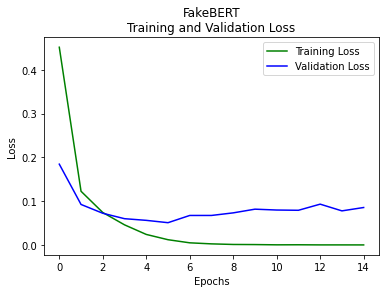

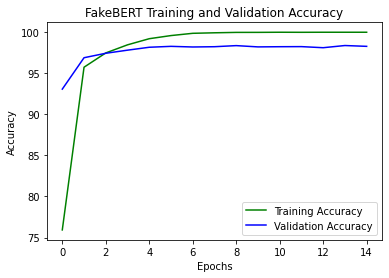

  0%|          | 0/25 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (5.068371648788452,47.7962962962963)


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4mv3k841 with config:
wandb: 	alt_test: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	emb_size: 768
wandb: 	epochs: 10
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.001
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: ada
wandb: 	rho: 0.9
wandb: 	test_data: LiarLiar
wandb: 	test_subset: False
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-b98c47b1c708a9da
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-fa4c060bb8bac118.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d24869627cdcd1e3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-81927da523dd770a.arrow
Using custom data configuration data-8d423b475df6a0fb
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


Using liar dataset for test...


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-eb32bb35da2fec80.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-7fbfb1c7d34f56b1.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   1    |   0.692782   |   51.24   |  0.691292  |   51.55   |  228.55  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   2    |   0.690043   |   52.92   |  0.690563  |   51.55   |  227.25  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   3    |   0.689628   |   53.12   |  0.689802  |   51.55   |  227.50  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   4    |   0.688499   |   53.34   |  0.688899  |   51.55   |  227.47  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   5    |   0.687993   |   53.66   |  0.688051  |   51.55   |  227.31  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   6    |   0.686852   |   53.73   |  0.687058  |   51.55   |  228.04  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   7    |   0.685706   |   53.68   |  0.685859  |   51.62   |  227.96  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   8    |   0.684872   |   54.27   |  0.684822  |   51.67   |  228.45  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   9    |   0.683717   |   54.21   |  0.683576  |   52.40   |  228.33  


  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  10    |   0.682101   |   55.25   |  0.682384  |   52.69   |  228.41  


Training complete! Best accuracy: 52.69%.
epochs: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] 
train_loss: [0.69278203 0.69004259 0.68962841 0.68849942 0.68799304 0.68685163
 0.68570556 0.68487226 0.68371658 0.68210111] 
val_loss: [0.69129248 0.6905626  0.68980233 0.68889875 0.68805079 0.6870577
 0.68585895 0.68482216 0.68357588 0.68238372]


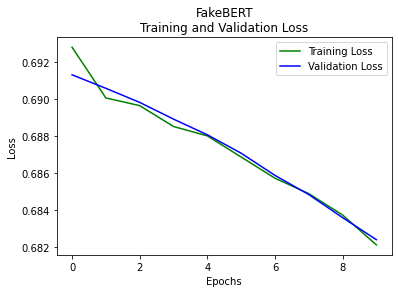

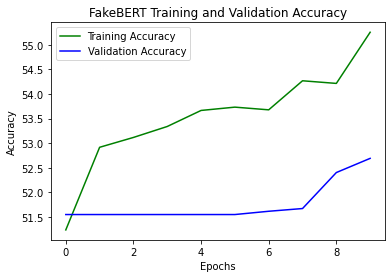

  0%|          | 0/25 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.7388909673690796,42.9375)


In [21]:
# wandb experiment code
from source import train, evaluate
from source.dataloader.get_data import bert_data
from source.models.FakeBERT import initialize_model, FakeBERTCNN
from source.plot import experiment_plot
import wandb
import pprint

def run():
  with wandb.init(project="FakeBERT_Colleen", entity="cs7643-teamscam") as run:
    config = wandb.config
    # Parameters
    MAX_LENGTH = config["max_length"]
    EPOCHS = config['epochs']
    BATCH_SIZE = config["batch_size"]
    NUM_TOKENS, EMBEDDING_SIZE = (MAX_LENGTH, config['emb_size']) # The num_tokens comes from max_length in tokens
    NUM_FILTERS = config['num_filters'] # [128, 128, 128] in paper
    FILTER_SIZES = config['filter_sizes'] #[3,4,5] in paper
    DROPOUT = config["dropout"]
    LR = config["learning_rate"]
    RHO = config['rho']
    EMB_SIZE = config['emb_size']
    NUM_CLASSES = config['num_classes']
    ALT_TEST = config['alt_test']
    TEST_SUBSET = config['test_subset'] # Whether or not to get a reduced size dataset (700,200,100) in train, validation, test
    FINAL_LAYER = 0 # Get BERT embeddings
    TEST_DATA = config['test_data']

    # Define the dataset 
    data = bert_data(\
                      data_folder = 'data',\
                      train_file = 'Train_Clean.csv',\
                      test_file = 'Test_Clean.csv',\
                      val_file = 'Validate_Clean.csv',\
                      tokenizer_type = 'bert-base-uncased',\
                      data_tokens = None)

    # FYI - col_tokenize is name of column containing the sequence text (in case it changes for some reason)
    data_tokenized = data.tokenize(\
                                    col_tokenize = 'text',\
                                    add_special_tokens = True,\
                                    max_length = MAX_LENGTH,\
                                    truncation = True,\
                                    padding = 'max_length')

    # Get train, validation data
    train_dataloader, val_dataloader, test_dataloader = data.get_data_loader(batch_size=BATCH_SIZE, test_subset=TEST_SUBSET)

    # Create DataLoader for alternate test data
    if ALT_TEST:
      print('Using liar dataset for test...')
      test_dataloader =  bert_data.get_test_data_loader(\
                                            data_folder = 'data',\
                                            data_test = 'Clean_Liar_Test.csv',\
                                            max_length = MAX_LENGTH,\
                                            batch_size = BATCH_SIZE)

    # Specify loss function
    loss_fn = nn.CrossEntropyLoss()

    set_seed(42)
    cnn_bert = initialize_model(device, max_len=MAX_LENGTH, filter_sizes=FILTER_SIZES,
                                num_filters=NUM_FILTERS, num_classes=NUM_CLASSES,
                                learning_rate=LR, dropout=DROPOUT)

    # Specify the optimizer
    if (config['opt'] == 'adam'): 
      opt = Adam(cnn_bert.parameters(), lr=LR)
    else:
      opt = Adadelta(cnn_bert.parameters(), lr=LR, rho=RHO)

    results = train.train(emb_model = bert_model, \
                model = cnn_bert,\
                loss_fn = loss_fn,\
                optimizer = opt,\
                train_dataloader = train_dataloader,\
                val_dataloader = val_dataloader,\
                epochs=EPOCHS,\
                bert_layer = FINAL_LAYER)

    plot_runner = experiment_plot(results = results,\
                                  save_name = "FakeBERT_Colleen" + '-' \
                                            + 'SEQ' + str(MAX_LENGTH)\
                                            + '-LR' + str(LR)\
                                            + '-DO' + str(DROPOUT)\
                                            + '-BS' + str(BATCH_SIZE),
                                  save_path = "source/experiments/figures/",\
                                  append_time = True
                                  )
    plot_runner.plot(title_prepend = "FakeBERT",\
                    include_points = False)

    test_loss, test_accuracy = evaluate.evaluate(bert_model, cnn_bert, loss_fn, test_dataloader, FINAL_LAYER, epoch_i = 'Test')
    wandb.log({'test_data':TEST_DATA})
    wandb.log({'test_loss':test_loss})
    wandb.log({'test_acc':test_accuracy})
    print('Final Loss and Accuracy on Test: (%s,%s)' % (test_loss, test_accuracy))
    
count = 10   # number of runs to execute
sweep_id = wandb.sweep(sweep_config, project="FakeBERT_Colleen", entity="cs7643-teamscam")
wandb.agent(sweep_id, function=run, count=count)


In [ ]:
# SWEEP # 2
# set sweep configuration
sweep_config = {
    'method': 'random',#grid, random
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'learning_rate': {
            'values': [1e-3]#, 1e-2
        },
        'batch_size': {
            'values': [128]#32, 
        },
        'epochs':{
            'values':[10]#5, 
        },
        'max_length':{
            'values':[200,300]#, 200, 300
        },
        'dropout':{
            'values':[0.0, 0.2]
        },
        'opt':{
            'values':['ada']
        },
        'rho':{
            'values':[0.95]
        },
        'emb_size':{ # should not change
            'value':768
        },
        'num_filters':{
            'value':[128, 128, 128] # [128, 128, 128] in paper
        },
        'filter_sizes':{
            'value':[3, 4, 5] # in paper
        },
        'num_classes':{ # should not change (with standard dataset)
            'value':2
        },
        'test_subset':{
            'value': False
        },
        'test_data': {
            'value':'LiarLiar' #'ISOT'
        },
        'alt_test':{
            'value': True
        }
    }
}

Create sweep with ID: t3zijvgz
Sweep URL: https://wandb.ai/cs7643-teamscam/FakeBERT_Colleen/sweeps/t3zijvgz


wandb: Agent Starting Run: 56w4xmpg with config:
wandb: 	alt_test: True
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	emb_size: 768
wandb: 	epochs: 10
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.001
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: ada
wandb: 	rho: 0.95
wandb: 	test_data: LiarLiar
wandb: 	test_subset: False
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-b98c47b1c708a9da
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-fa4c060bb8bac118.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d24869627cdcd1e3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-81927da523dd770a.arrow
Using custom data configuration data-8d423b475df6a0fb
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


Using liar dataset for test...


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-eb32bb35da2fec80.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-7fbfb1c7d34f56b1.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   1    |   0.691850   |   52.41   |  0.691688  |   51.67   |  204.39  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   2    |   0.690918   |   52.79   |  0.691303  |   51.67   |  203.17  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   3    |   0.690213   |   52.79   |  0.690920  |   51.67   |  203.37  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   4    |   0.690059   |   52.74   |  0.690425  |   51.67   |  203.16  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   5    |   0.689396   |   52.69   |  0.689993  |   51.67   |  203.33  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   6    |   0.689087   |   52.84   |  0.689512  |   51.67   |  203.19  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   7    |   0.688337   |   52.85   |  0.688962  |   51.67   |  203.17  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   8    |   0.688053   |   52.91   |  0.688482  |   51.67   |  203.13  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   9    |   0.687599   |   53.00   |  0.687929  |   51.67   |  203.26  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  10    |   0.687162   |   53.28   |  0.687436  |   51.67   |  203.64  


Training complete! Best accuracy: 51.67%.
epochs: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] 
train_loss: [0.69184961 0.69091841 0.69021311 0.69005889 0.6893965  0.68908731
 0.68833713 0.6880532  0.68759915 0.68716176] 
val_loss: [0.69168833 0.69130307 0.69091989 0.69042482 0.68999325 0.68951219
 0.6889617  0.68848177 0.68792911 0.68743634]


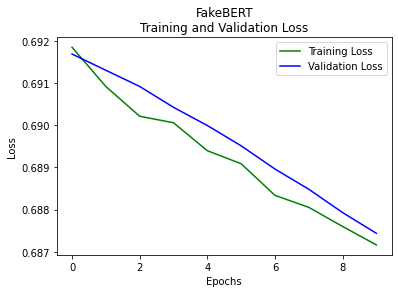

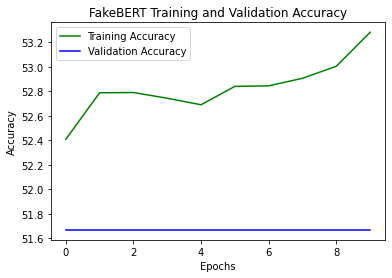

  0%|          | 0/13 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.7176805688784673,43.20913461538461)


wandb: Agent Starting Run: dlfhtq0m with config:
wandb: 	alt_test: True
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	emb_size: 768
wandb: 	epochs: 10
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.001
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: ada
wandb: 	rho: 0.95
wandb: 	test_data: LiarLiar
wandb: 	test_subset: False
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-b98c47b1c708a9da
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-fa4c060bb8bac118.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d24869627cdcd1e3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-81927da523dd770a.arrow
Using custom data configuration data-8d423b475df6a0fb
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


Using liar dataset for test...


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-eb32bb35da2fec80.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-7fbfb1c7d34f56b1.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   1    |   0.691850   |   52.41   |  0.691688  |   51.67   |  204.28  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   2    |   0.690918   |   52.79   |  0.691303  |   51.67   |  203.43  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   3    |   0.690213   |   52.79   |  0.690920  |   51.67   |  203.41  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   4    |   0.690059   |   52.74   |  0.690425  |   51.67   |  203.20  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   5    |   0.689396   |   52.69   |  0.689993  |   51.67   |  203.58  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   6    |   0.689087   |   52.84   |  0.689512  |   51.67   |  203.26  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   7    |   0.688337   |   52.85   |  0.688962  |   51.67   |  203.43  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   8    |   0.688053   |   52.91   |  0.688482  |   51.67   |  203.41  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   9    |   0.687599   |   53.00   |  0.687929  |   51.67   |  203.35  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  10    |   0.687162   |   53.28   |  0.687436  |   51.67   |  203.68  


Training complete! Best accuracy: 51.67%.
epochs: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] 
train_loss: [0.69184961 0.69091841 0.69021311 0.69005889 0.6893965  0.68908731
 0.68833713 0.6880532  0.68759915 0.68716176] 
val_loss: [0.69168833 0.69130307 0.69091989 0.69042482 0.68999325 0.68951219
 0.6889617  0.68848177 0.68792911 0.68743634]


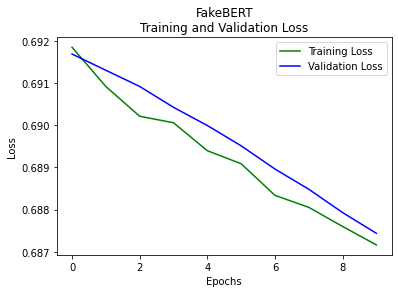

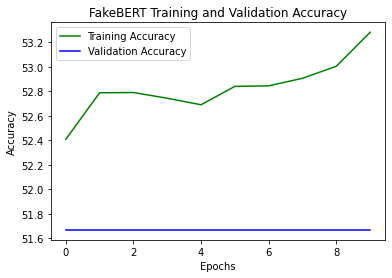

  0%|          | 0/13 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.7176805688784673,43.20913461538461)


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 51sv1noe with config:
wandb: 	alt_test: True
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	emb_size: 768
wandb: 	epochs: 10
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.001
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: ada
wandb: 	rho: 0.95
wandb: 	test_data: LiarLiar
wandb: 	test_subset: False
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-b98c47b1c708a9da
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-fa4c060bb8bac118.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d24869627cdcd1e3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-81927da523dd770a.arrow
Using custom data configuration data-8d423b475df6a0fb
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


Using liar dataset for test...


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-eb32bb35da2fec80.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-7fbfb1c7d34f56b1.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   1    |   0.691850   |   52.41   |  0.691688  |   51.67   |  204.76  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   2    |   0.690918   |   52.79   |  0.691303  |   51.67   |  204.76  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   3    |   0.690213   |   52.79   |  0.690920  |   51.67   |  203.49  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   4    |   0.690059   |   52.74   |  0.690425  |   51.67   |  203.73  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   5    |   0.689396   |   52.69   |  0.689993  |   51.67   |  203.48  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   6    |   0.689087   |   52.84   |  0.689512  |   51.67   |  204.10  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   7    |   0.688337   |   52.85   |  0.688962  |   51.67   |  203.58  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   8    |   0.688053   |   52.91   |  0.688482  |   51.67   |  203.52  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   9    |   0.687599   |   53.00   |  0.687929  |   51.67   |  203.88  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  10    |   0.687162   |   53.28   |  0.687436  |   51.67   |  203.68  


Training complete! Best accuracy: 51.67%.
epochs: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] 
train_loss: [0.69184961 0.69091841 0.69021311 0.69005889 0.6893965  0.68908731
 0.68833713 0.6880532  0.68759915 0.68716176] 
val_loss: [0.69168833 0.69130307 0.69091989 0.69042482 0.68999325 0.68951219
 0.6889617  0.68848177 0.68792911 0.68743634]


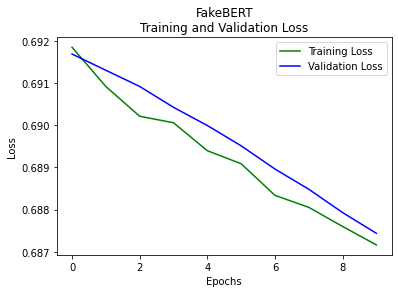

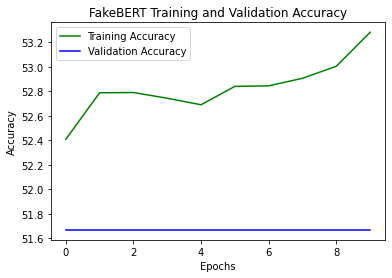

  0%|          | 0/13 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.7176805688784673,43.20913461538461)


wandb: Agent Starting Run: 1nn5yk8e with config:
wandb: 	alt_test: True
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	emb_size: 768
wandb: 	epochs: 10
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.001
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: ada
wandb: 	rho: 0.95
wandb: 	test_data: LiarLiar
wandb: 	test_subset: False
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-b98c47b1c708a9da
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-fa4c060bb8bac118.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d24869627cdcd1e3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-81927da523dd770a.arrow
Using custom data configuration data-8d423b475df6a0fb
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


Using liar dataset for test...


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-eb32bb35da2fec80.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-7fbfb1c7d34f56b1.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   1    |   0.691850   |   52.41   |  0.691688  |   51.67   |  204.28  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   2    |   0.690918   |   52.79   |  0.691303  |   51.67   |  204.61  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   3    |   0.690213   |   52.79   |  0.690920  |   51.67   |  203.74  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   4    |   0.690059   |   52.74   |  0.690425  |   51.67   |  203.58  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   5    |   0.689396   |   52.69   |  0.689993  |   51.67   |  203.57  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   6    |   0.689087   |   52.84   |  0.689512  |   51.67   |  203.49  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   7    |   0.688337   |   52.85   |  0.688962  |   51.67   |  203.48  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   8    |   0.688053   |   52.91   |  0.688482  |   51.67   |  204.57  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   9    |   0.687599   |   53.00   |  0.687929  |   51.67   |  203.65  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  10    |   0.687162   |   53.28   |  0.687436  |   51.67   |  203.52  


Training complete! Best accuracy: 51.67%.
epochs: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] 
train_loss: [0.69184961 0.69091841 0.69021311 0.69005889 0.6893965  0.68908731
 0.68833713 0.6880532  0.68759915 0.68716176] 
val_loss: [0.69168833 0.69130307 0.69091989 0.69042482 0.68999325 0.68951219
 0.6889617  0.68848177 0.68792911 0.68743634]


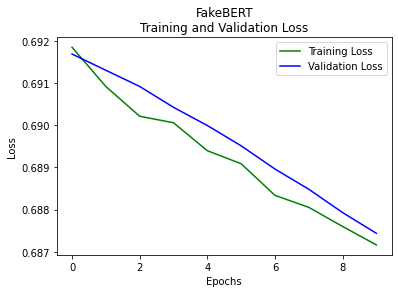

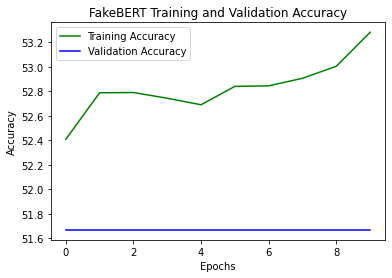

  0%|          | 0/13 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.7176805688784673,43.20913461538461)


wandb: Agent Starting Run: 80vue1zq with config:
wandb: 	alt_test: True
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	emb_size: 768
wandb: 	epochs: 10
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.001
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: ada
wandb: 	rho: 0.95
wandb: 	test_data: LiarLiar
wandb: 	test_subset: False
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-b98c47b1c708a9da
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-fa4c060bb8bac118.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d24869627cdcd1e3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-b98c47b1c708a9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-81927da523dd770a.arrow
Using custom data configuration data-8d423b475df6a0fb
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


Using liar dataset for test...


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-eb32bb35da2fec80.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-8d423b475df6a0fb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-7fbfb1c7d34f56b1.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   1    |   0.691850   |   52.41   |  0.691688  |   51.67   |  204.39  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   2    |   0.690918   |   52.79   |  0.691303  |   51.67   |  203.51  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   3    |   0.690213   |   52.79   |  0.690920  |   51.67   |  203.68  


  0%|          | 0/211 [00:00<?, ?it/s]

In [ ]:
# wandb experiment code
from source import train, evaluate
from source.dataloader.get_data import bert_data
from source.models.FakeBERT import initialize_model, FakeBERTCNN
from source.plot import experiment_plot
import wandb
import pprint

def run():
  with wandb.init(project="FakeBERT_Colleen", entity="cs7643-teamscam") as run:
    config = wandb.config
    # Parameters
    MAX_LENGTH = config["max_length"]
    EPOCHS = config['epochs']
    BATCH_SIZE = config["batch_size"]
    NUM_TOKENS, EMBEDDING_SIZE = (MAX_LENGTH, config['emb_size']) # The num_tokens comes from max_length in tokens
    NUM_FILTERS = config['num_filters'] # [128, 128, 128] in paper
    FILTER_SIZES = config['filter_sizes'] #[3,4,5] in paper
    DROPOUT = config["dropout"]
    LR = config["learning_rate"]
    RHO = config['rho']
    EMB_SIZE = config['emb_size']
    NUM_CLASSES = config['num_classes']
    ALT_TEST = config['alt_test']
    TEST_SUBSET = config['test_subset'] # Whether or not to get a reduced size dataset (700,200,100) in train, validation, test
    FINAL_LAYER = 0 # Get BERT embeddings
    TEST_DATA = config['test_data']

    # Define the dataset 
    data = bert_data(\
                      data_folder = 'data',\
                      train_file = 'Train_Clean.csv',\
                      test_file = 'Test_Clean.csv',\
                      val_file = 'Validate_Clean.csv',\
                      tokenizer_type = 'bert-base-uncased',\
                      data_tokens = None)

    # FYI - col_tokenize is name of column containing the sequence text (in case it changes for some reason)
    data_tokenized = data.tokenize(\
                                    col_tokenize = 'text',\
                                    add_special_tokens = True,\
                                    max_length = MAX_LENGTH,\
                                    truncation = True,\
                                    padding = 'max_length')

    # Get train, validation data
    train_dataloader, val_dataloader, test_dataloader = data.get_data_loader(batch_size=BATCH_SIZE, test_subset=TEST_SUBSET)

    # Create DataLoader for alternate test data
    if ALT_TEST:
      print('Using liar dataset for test...')
      test_dataloader =  bert_data.get_test_data_loader(\
                                            data_folder = 'data',\
                                            data_test = 'Clean_Liar_Test.csv',\
                                            max_length = MAX_LENGTH,\
                                            batch_size = BATCH_SIZE)

    # Specify loss function
    loss_fn = nn.CrossEntropyLoss()

    set_seed(42)
    cnn_bert = initialize_model(device, max_len=MAX_LENGTH, filter_sizes=FILTER_SIZES,
                                num_filters=NUM_FILTERS, num_classes=NUM_CLASSES,
                                learning_rate=LR, dropout=DROPOUT)

    # Specify the optimizer
    if (config['opt'] == 'adam'): 
      opt = Adam(cnn_bert.parameters(), lr=LR)
    else:
      opt = Adadelta(cnn_bert.parameters(), lr=LR, rho=RHO)

    results = train.train(emb_model = bert_model, \
                model = cnn_bert,\
                loss_fn = loss_fn,\
                optimizer = opt,\
                train_dataloader = train_dataloader,\
                val_dataloader = val_dataloader,\
                epochs=EPOCHS,\
                bert_layer = FINAL_LAYER)

    plot_runner = experiment_plot(results = results,\
                                  save_name = "FakeBERT_Colleen" + '-' \
                                            + 'SEQ' + str(MAX_LENGTH)\
                                            + '-LR' + str(LR)\
                                            + '-DO' + str(DROPOUT)\
                                            + '-BS' + str(BATCH_SIZE),
                                  save_path = "source/experiments/figures/",\
                                  append_time = True
                                  )
    plot_runner.plot(title_prepend = "FakeBERT",\
                    include_points = False)

    test_loss, test_accuracy = evaluate.evaluate(bert_model, cnn_bert, loss_fn, test_dataloader, FINAL_LAYER, epoch_i = 'Test')
    wandb.log({'test_data':TEST_DATA})
    wandb.log({'test_loss':test_loss})
    wandb.log({'test_acc':test_accuracy})
    print('Final Loss and Accuracy on Test: (%s,%s)' % (test_loss, test_accuracy))
    
count = 6   # number of runs to execute
sweep_id = wandb.sweep(sweep_config, project="FakeBERT_Colleen", entity="cs7643-teamscam")
wandb.agent(sweep_id, function=run, count=count)


In [ ]:
# old experiment code (no wandb)
from source import train
from source.models.FakeBERT import initialize_model, FakeBERTCNN
from source.plot import experiment_plot

# Parameters
MAX_LENGTH = 100
BATCH_SIZE = 128
EPOCHS = 10
N_SEQUENCES = data_tokenized['train'].shape[0]
NUM_TOKENS, EMBEDDING_SIZE = (MAX_LENGTH, 768) # The num_tokens comes from max_length in tokens
NUM_FILTERS = [128, 128, 128]
FILTER_SIZES = [3, 4, 5]
NUM_CLASSES = 2
DROPOUT = 0.2
LR = 0.1
TEST_SUBSET = False
EMB_LAYER = 0

# Get train, validation data
train_dataloader, val_dataloader, test_dataloader = bert_data.get_data_loader(batch_size=BATCH_SIZE, test_subset=TEST_SUBSET)

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

set_seed(42)
cnn_bert = initialize_model(device, max_len=MAX_LENGTH, filter_sizes=FILTER_SIZES,
                            num_filters=NUM_FILTERS, num_classes=NUM_CLASSES,
                            learning_rate=LR, dropout=DROPOUT)

# Optimizer
optimizer = Adadelta(cnn_bert.parameters(), lr=LR, rho=0.95)
# optimizer = Adam(cnn_bert.parameters(), lr=LR)

results = train.train(emb_model = bert_model, \
            model = cnn_bert,\
            loss_fn = loss_fn,\
            optimizer = optimizer,\
            train_dataloader = train_dataloader,\
            val_dataloader = val_dataloader,\
            epochs=EPOCHS)

Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   1    |   0.629730   |   62.84   |  0.408728  |   84.79   |  118.34  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   2    |   0.263905   |   89.42   |  0.165536  |   93.76   |  117.98  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   3    |   0.138505   |   95.00   |  0.125533  |   95.39   |  118.09  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   4    |   0.099664   |   96.56   |  0.124694  |   95.39   |  117.84  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   5    |   0.067582   |   97.71   |  0.158894  |   93.80   |  117.74  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   6    |   0.045999   |   98.56   |  0.081638  |   97.00   |  117.78  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   7    |   0.024629   |   99.23   |  0.087602  |   97.20   |  118.06  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   8    |   0.011300   |   99.74   |  0.084263  |   97.27   |  117.96  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

   9    |   0.005252   |   99.91   |  0.097501  |   97.34   |  117.89  


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  10    |   0.002518   |   99.99   |  0.098334  |   97.43   |  117.85  


Training complete! Best accuracy: 97.43%.


In [ ]:
eps = results[:,0]
train_losses = results[:,1]
train_accys = results[:,2]
val_losses = results[:,3]
val_accys = results[:,4]

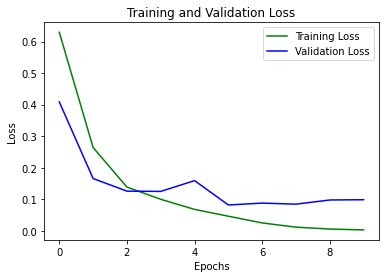

In [ ]:
plt.plot(eps, train_losses, 'g', label='Training Loss')
plt.plot(eps, val_losses, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.close()

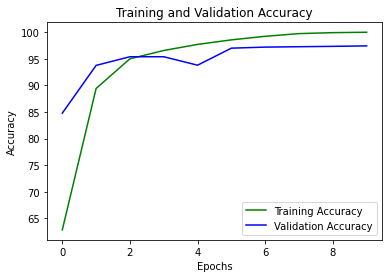

In [ ]:
plt.plot(eps, train_accys, 'g', label='Training Accuracy')
plt.plot(eps, val_accys, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.close()

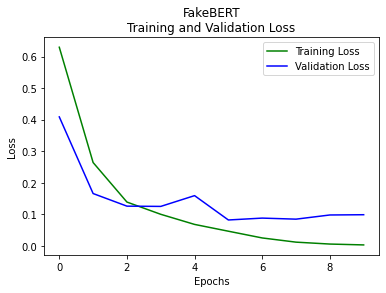

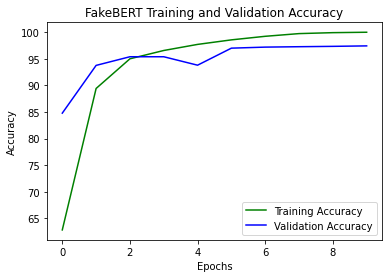

In [ ]:
plot_runner = experiment_plot(results = results,\
                              save_name = "FakeBERT" + '-' \
                                        + 'SEQ' + str(MAX_LENGTH)\
                                        + '-LR' + str(LR)\
                                        + '-DO' + str(DROPOUT)\
                                        + '-BS' + str(BATCH_SIZE),
                              save_path = "source/experiments/figures/",\
                              append_time = True
                              )
plot_runner.plot(title_prepend = "FakeBERT",\
                 include_points = False)

In [ ]:
# from source.plot import experiment_plot
# plot_runner = experiment_plot(results = results)
# plot_runner.plot()

In [ ]:
!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7097 sha256=7e2d3645310066b6d8a914d01d295a7a5218050cbb95d7c4150122c16915583e
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText


### evaluate model performance on test data

In [ ]:
evaluate(cnn_bert, val_dataloader)

### References

https://romanorac.github.io/machine/learning/2019/12/02/identifying-hate-speech-with-bert-and-cnn.html